In [99]:
import os
import collections
from collections import defaultdict
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
from langdetect import detect, LangDetectException

import matplotlib.pyplot as plt
from adjustText import adjust_text

In [100]:
import langid

bigram = "bonjour"  # Replace with your bigram
language, _ = langid.classify(bigram)
print("Detected language:", language)

color_mapping = {
    'fr-en': '#0055A4',   # France - Blue
    'es-en': '#FF9900',   # Spain - Orange
    'it-en': '#008C45',   # Italy - Green
    'de-en': '#FFCC00',   # Germany - Yellow
    'cs-en': '#D7141A',   # Czech Republic - Red
    'hu-en': '#8B4513'    # Hungary - SaddleBrown
}


Detected language: en


In [101]:
# lang params
N_GRAMS = 2
BASE_DIR = f"./results/n-grams/exp_full"
BASE_PATH = os.path.join(BASE_DIR, f"{N_GRAMS}")
BASE_PATH_COMMON = os.path.join(BASE_PATH, "all")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
FILTER_CHARS = False
DETECT_LANG = False

# model params
base_results_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_3/inference/EleutherAI"
models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m',]

In [102]:
n_gram_freqs_path = "./results/n-grams/exp_full/2/common/pl-en-2-grams.pkl"
n_gram_freqs = pickle.load(open(n_gram_freqs_path, "rb"))
n_gram_freqs = dict(sorted(n_gram_freqs.items(), key=lambda item: item[1]['value'], reverse=True))
# # export as text
# # with open("n_gram_freqs.txt", "w") as f:
# #     for k, v in n_gr
# # 3am_freqs.items():
# #         f.write(f"{k}: {v}\n")
# LANGUAGES = ['ru-en', 'fr-en', 'ro-en', 'de-en', 'pl-en', 'cs-en']
# LANGUAGES = ['ru-en', 'ro-en', 'de-en', 'pl-en', 'cs-en', 'fr-en', 'ja-en', 'zh-en']

# wmt09
LANGUAGES = ['wmt09-cs-en', 'wmt09-de-en', 'wmt09-fr-en', 'wmt09-es-en', 'wmt09-it-en', 'wmt09-hu-en']
TASKS = LANGUAGES

LANGUAGES_STR = "_".join(LANGUAGES)
PLOT_PATH = f"./results/n-grams/exp_full/{N_GRAMS}/plots/{LANGUAGES_STR}_filter_{FILTER_CHARS}"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

In [103]:
from src.wimbd_ import WimbdAnalysis, load_mmlu
wa = WimbdAnalysis(BASE_PATH, TASKS, N_GRAMS, FILTER_CHARS)

In [104]:
def calc_coverage(df):
    zero = df[df['value'] == 0]
    non_zero = df[df['value'] > 0]
    return len(non_zero) / (len(zero) + len(non_zero))

def filter_by_language(data, language):
    return {k: v for k, v in data.items() if v['lang'] == language}

def sum_values(data):
    return sum(item['value'] for item in data.values())

def filter_by_language(df, lang):
    # Define a mapping from ISO 639-1 language codes to langdetect language codes
    lang_map = {
        'ja': 'ja',
        'ru': 'ru',
        'zh': 'zh-cn',
        'fr': 'fr',
        'ro': 'ro',
        'de': 'de',
        'cs': 'cs',
        'pl': 'pl',
        'hu': 'hu',
        'it': 'it',
        'es': 'es',
        'wmt09-cs': 'cs',  # Add WMT09 specific mappings
        'wmt09-de': 'de',
        'wmt09-fr': 'fr',
        'wmt09-es': 'es',
        'wmt09-it': 'it',
        'wmt09-hu': 'hu',
    }

    # Get the langdetect language code
    langdetect_code = lang_map.get(lang)
    if not langdetect_code:
        print(f"Warning: No language mapping found for {lang}")
        return df

    # Make sure the language column exists
    if lang not in df.columns:
        print(f"Warning: Column {lang} not found in DataFrame. Available columns: {df.columns}")
        # Try to find the correct column by checking if any column ends with the language code
        lang_cols = [col for col in df.columns if col.endswith(f"-{lang}") or col.startswith(f"{lang}-")]
        if lang_cols:
            lang = lang_cols[0]
        else:
            print(f"No suitable column found for language {lang}")
            return df

    # Filter the DataFrame
    def detect_lang(text):
        try:
            return detect(text) == langdetect_code
        except LangDetectException:
            return False

    # Add a progress bar
    pbar = tqdm(total=len(df), desc=f"Filtering by language {lang}")
    df_filtered = df[df[lang].apply(lambda x: detect_lang(x) if isinstance(x, str) else False)]
    pbar.update(len(df))
    pbar.close()

    return df_filtered

def filter_chars_by_language(df, lang, filter_chars=False):
    regex_patterns = {
        "ja": r'[一-龯ぁ-んァ-ンａ-ｚＡ-Ｚ々〆〤]',
        "ru": r'[а-яА-ЯёЁ]',
        "zh": r'[一-龯]',
        "fr": r'[àâéèêëîïôùûüÿçœæÀÂÉÈÊËÎÏÔÙÛÜŸÇŒÆ]',
        "ro": r'[ăâîșțĂÂÎȘȚ]',
        "de": r'[äöüÄÖÜß]',
        "cs": r'[áčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ]',
        # Add more patterns for other languages here
    }

    if filter_chars:
        lang_regex = regex_patterns.get(lang)
        print(f"Filtering by regex: {lang_regex}")
        if lang_regex:
            df = df[df[lang].str.contains(lang_regex, regex=True, na=False)]
    
    return df

def check_language_df(df, lang):
    print(f"Filtering by language: {lang}")
    df_filtered = df[df[lang].apply(lambda x: check_language(x, lang), pbar.update(1))]
    return df_filtered

def prepare_ngram_df(n_gram_freqs_path, is_all=False, 
                     filter_chars=False, detect_lang=False):
    """
    example usage
    # n_gram_freqs, df_clean = prepare_ngram_df(n_gram_freqs_path, filter_chars=FILTER_CHARS)
    """
    with open(n_gram_freqs_path, "rb") as f:
        n_gram_freqs = pickle.load(f)
    n_gram_freqs = dict(sorted(n_gram_freqs.items(), key=lambda item: item[1]['value'], reverse=True))
    languages = n_gram_freqs_path.split("/")[-1].split("-")[:2]
    target_language = languages[0]
    df = pd.DataFrame(n_gram_freqs).T
    df['coverage'] = calc_coverage(df)
    df = df[df['value'] > 0]
    if is_all:
        df = df.reset_index().rename(columns={"index": target_language})
        df = df.drop(columns=['language'])
        df = filter_by_language(df, target_language)
    else:
        df = df.reset_index().rename(columns={"level_0": target_language, "level_1": languages[1]})
    
    non_zero_vals = df[df['value'] > 0]
    non_zero_vals_mean = non_zero_vals['value'].mean()
    non_zero_vals_std = non_zero_vals['value'].std()
    # Remove outliers
    df = df[df['value'] < non_zero_vals_mean + 0.5 * non_zero_vals_std]

    if filter_chars:
        print(f"df cols: {df.columns}")
        df = filter_by_language(df, target_language)
    if detect_lang:
        df = check_language_df(df, target_language)

    return n_gram_freqs, df


def get_lang_dfs(base_path, datasets, **kwargs):
    lang_pairs = [lang.split('-')[-2:] for lang in datasets]
    # get all files with .pkl extension within base_path
    files = [file for file in os.listdir(base_path) if file.endswith(".pkl")]
    # only keep files with languages in langs
    files = [file for file in files if any([('-'.join(lang) in file) for lang in lang_pairs])]
    # load files clean them and add them to dict
    lang_dfs = {}
    for file in files:
        n_gram_freqs, df_clean = prepare_ngram_df(os.path.join(base_path, file), **kwargs)
        languages = "-".join(file.split("/")[-1].split("-")[:2])
        lang_dfs[languages] = df_clean
        # export
        df_clean.to_csv(os.path.join(base_path, f"{file}.csv"), index=False)
    return lang_dfs


def load_all(ext="all.pkl.csv"):
    files = [file for file in os.listdir(BASE_PATH_ALL) if file.endswith(ext)]
    n_gram_freqs_all = {}
    for file in files:
        print(f"Loading {file}")
        with open(os.path.join(BASE_PATH_ALL, file), "rb") as f:
            lang_pair = file.split(".")[0].split("-")
            lang_pair = "-".join(lang_pair[:2])
            n_gram_freqs_all[lang_pair] = pd.read_csv(f)
    return n_gram_freqs_all


def plot_n_samples(df_dict, color_map):
    # Prepare data for plotting
    langs = []
    total_samples = []
    for lang, df in df_dict.items():
        langs.append(lang)
        total_samples.append(df['value'].sum())

    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        'Language': langs,
        'Total Samples': total_samples
    })

    # Sort the DataFrame by total samples
    plot_df = plot_df.sort_values('Total Samples', ascending=False)

    # Create a color list corresponding to languages
    colors = [color_map[lang] for lang in plot_df['Language']]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(plot_df['Language'], plot_df['Total Samples'], color=colors)
    plt.xlabel('Language')
    plt.ylabel('Total (x,y) Pairs')
    plt.title('Total (x,y) Pairs for Each Language')
    plt.xticks(rotation=45)
    plt.tight_layout()
    savefile = f"{PLOT_PATH}/total_samples.pdf"
    plt.savefig(f"{PLOT_PATH}/total_samples.png")
    plt.savefig(f"{PLOT_PATH}/total_samples.pdf")
    print(f"Saved plots to {savefile}")
    plt.show()

def plot_distribution(df, lang, ax=None, color=None): 
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(df['value'], bins=50, log=True, color=color)
    ax.set_title(f'{lang}', fontsize=20)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Count')
    savefile = f"{PLOT_PATH}/{lang}_hist.pdf"
    plt.savefig(f"{PLOT_PATH}/{lang}_hist.png")
    if ax is None:
        plt.show()

def plot_cumulative_distribution(df, lang, ax=None, color=None):
    if ax is None:
        fig, ax = plt.subplots()
    values_list_sorted = np.sort(df['value'])
    cumulative_frequencies = np.cumsum(values_list_sorted)
    cdf = cumulative_frequencies / float(cumulative_frequencies[-1])
    ax.scatter(values_list_sorted, cdf, color=color)
    ax.plot(values_list_sorted, cdf, color=color)
    ax.set_title(f'{lang}', fontsize=20)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Cumulative Distribution')
    plt.savefig(f"{PLOT_PATH}/{lang}.png")
    if ax is None:
        plt.show()

def analyze_and_plot_distributions(lang_dfs, color_mapping):
    # Create a color palette
    colors = sns.color_palette('hls', len(lang_dfs)) if color_mapping is None else color_mapping
    # colors = 

    # set fontsize to 14
    plt.rcParams.update({'font.size': 14})

    # Create figures for the plots
    fig1, axs1 = plt.subplots(1, len(lang_dfs), figsize=(7.5*len(lang_dfs), 5))
    fig2, axs2 = plt.subplots(1, len(lang_dfs), figsize=(5*len(lang_dfs), 5))
    
    # Now you can use this dictionary to get the color for each language
    for i, (lang, df) in enumerate(lang_dfs.items()):
        plot_distribution(df, lang, axs1[i], color=colors[lang])
        # plot_cumulative_distribution(df, lang, axs2[i], color=colors[lang]) # color_mapping[lang]
    
    savefile = f"{PLOT_PATH}/distributions_1.pdf"
    plt.savefig(f"{PLOT_PATH}/distributions.png")
    plt.savefig(savefile)
    print(f"Saved plots to {savefile}")
    # Adjust the layout and show the plots
    plt.tight_layout()
    plt.show()

def plot_bleu_scores(bleu_scores, models, color_mapping):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = []

    for dataset in bleu_scores:
        scores = [bleu_scores[dataset][model] for model in models]
        bar = ax.bar(models, scores, color=color_mapping[dataset], alpha=0.5)
        bars.append(bar)

    ax.set_xlabel('Models')
    ax.set_ylabel('BLEU Score')
    ax.set_title('BLEU Scores for Datasets')
    ax.legend(bars, bleu_scores.keys(), title="Datasets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def prepare_scores(bleu_scores, lang_dfs, models, **kwargs):
    model_scores = defaultdict(lambda: defaultdict(list))
    dataset_scores = defaultdict(lambda: defaultdict(list))

    for dataset in lang_dfs:
        for model in models:
            lang_df = lang_dfs[dataset]
            n_samples = lang_df['value'].sum()
            coverage = lang_df['coverage'].mean() if 'coverage' in lang_df else 0
            score = bleu_scores[dataset][model]
            model_scores[model]['score'].append(score)
            model_scores[model]['n_samples'].append(n_samples)
            model_scores[model]['coverage'].append(coverage)
            dataset_scores[dataset]['score'].append(score)
            dataset_scores[dataset]['n_samples'].append(n_samples)
            dataset_scores[dataset]['coverage'].append(coverage)

            for kwarg, value in kwargs.items():
                value = value[dataset]
                model_scores[model][kwarg].append(value)
                dataset_scores[dataset][kwarg].append(value)

    for model in model_scores:
        model_score = model_scores[model]
        # Create a sorted index based on n_samples
        sorted_index = sorted(range(len(model_score['n_samples'])), key=lambda k: model_score['n_samples'][k])
        # Use the sorted index to sort all three lists
        model_scores[model]['score'] = [model_score['score'][i] for i in sorted_index]
        model_scores[model]['n_samples'] = [model_score['n_samples'][i] for i in sorted_index]
        model_scores[model]['coverage'] = [model_score['coverage'][i] for i in sorted_index]

        for kwarg, value in kwargs.items():
            model_scores[model][kwarg] = [model_score[kwarg][i] for i in sorted_index]

    return model_scores, dataset_scores


def plot_scores(model_scores, dataset_scores,
                color_mapping, 
                model_color_mapping,
                x_key='n_samples', name=None):
    plt.figure(figsize=(10, 8))
    texts = []

    for model in model_scores:
        # Sort the data by x-values
        sorted_indices = np.argsort(model_scores[model][x_key])
        x_values = np.array(model_scores[model][x_key])[sorted_indices]
        y_values = np.array(model_scores[model]['score'])[sorted_indices]

        plt.plot(x_values, y_values, color=model_color_mapping[model], label=model)
        texts.append(plt.text(x_values[-1], y_values[-1], model, ha='left', va='bottom', fontsize=12))

    for dataset in dataset_scores:
        plt.scatter(dataset_scores[dataset][x_key], dataset_scores[dataset]['score'], 
                    color=color_mapping[dataset], label=dataset, s=100)

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    plt.xlabel(x_key, fontsize=15)
    plt.ylabel('BLEU Score', fontsize=15)
    plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
    if name is not None:
        plt.title(name)
    plt.savefig(os.path.join(PLOT_PATH, f"lang_scores_{name}"))

def plot_model_size_vs_scores(results_dict, models, model_param_map, color_mapping):
    for dataset in results_dict:
        scores = [results_dict[dataset][model] for model in models]
        plt.scatter([model_param_map[model] for model in models], scores, color=color_mapping[dataset], label=dataset)
        plt.plot([model_param_map[model] for model in models], scores, color=color_mapping[dataset])
    
    plt.axvline(x=1e09, color='black', linestyle='--')
    plt.text(1e09, 30, '1b', fontsize=12)
    plt.axvline(x=410e06, color='black', linestyle='--')
    plt.text(410e06, 30, '410M', fontsize=12)
    
    plt.title("Model Size vs. Dataset Scores")
    plt.xlabel("Number of Parameters")
    plt.ylabel("BLEU Score")
    plt.xscale('log')
    plt.legend()
    plt.show()

In [105]:
LANGUAGES

['wmt09-cs-en',
 'wmt09-de-en',
 'wmt09-fr-en',
 'wmt09-es-en',
 'wmt09-it-en',
 'wmt09-hu-en']

In [106]:
# lang_dfs = get_lang_dfs(BASE_PATH_COMMON, LANGUAGES, filter_chars=FILTER_CHARS)
lang_dfs_filtered = get_lang_dfs(BASE_PATH_COMMON, LANGUAGES, filter_chars=True)
# lang_dfs
lang_dfs_pth = "./results/n-grams/exp_full/2/common/lang_dfs_filter_charsFalse_percentile0.97.pkl"
with open(lang_dfs_pth, "rb") as f:
    lang_dfs = pickle.load(f)

# get total samples per language pair
lang_dfs_total_samples = {lang: df['value'].sum() for lang, df in lang_dfs.items()}
# colors = sns.color_palette('hls', len(lang_dfs))
# # color_mapping = {lang: color for lang, color in zip(lang_dfs.keys(), colors)}

df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language cs
df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language hu
df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language es
df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language it
df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language de
df cols: Index(['index', 'value', 'language', 'lang', 'coverage'], dtype='object')
No suitable column found for language fr


In [107]:
total_samples = 0
for lang, n_samples in lang_dfs_total_samples.items():
    total_samples += n_samples
print(f"Total samples: {total_samples}")

Total samples: 262510.0


In [108]:
save_path = f"./results/n-grams/exp_full/{N_GRAMS}/common"
# # for each language, save top 100 examples in a csv

# for lang, df in lang_dfs.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples.csv"), index=False)

# for lang, df in lang_dfs_filtered.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df = df.head(100)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples_filtered.csv"), index=False)

In [109]:
# n_gram_freqs_all = get_lang_dfs(BASE_PATH_ALL, datasets=LANGUAGES, is_all=True, filter_chars=FILTER_CHARS)
# print(n_gram_freqs_all.keys())

lang_dfs_all = load_all("all.pkl.csv")

Loading hu-en-2-grams-all.pkl.csv
Loading fr-en-2-grams-all.pkl.csv
Loading de-en-2-grams-all.pkl.csv
Loading cs-en-2-grams-all.pkl.csv
Loading it-en-2-grams-all.pkl.csv
Loading es-en-2-grams-all.pkl.csv


In [110]:
lang_dfs_all

# find length of each df 

for lang, df in lang_dfs_all.items():
    print(f"{lang}: {len(df)}")

hu-en: 34415
fr-en: 41670
de-en: 37881
cs-en: 36552
it-en: 39458
es-en: 41024


In [111]:
# n_gram_freqs.pop(('angela merkel', 'chancellor angela'))
n_gram_freqs_values = [v['value'] for v in n_gram_freqs.values()]
n_gram_freqs_values_cumsum = np.cumsum(n_gram_freqs_values)

Saved plots to ./results/n-grams/exp_full/2/plots/wmt09-cs-en_wmt09-de-en_wmt09-fr-en_wmt09-es-en_wmt09-it-en_wmt09-hu-en_filter_False/total_samples.pdf


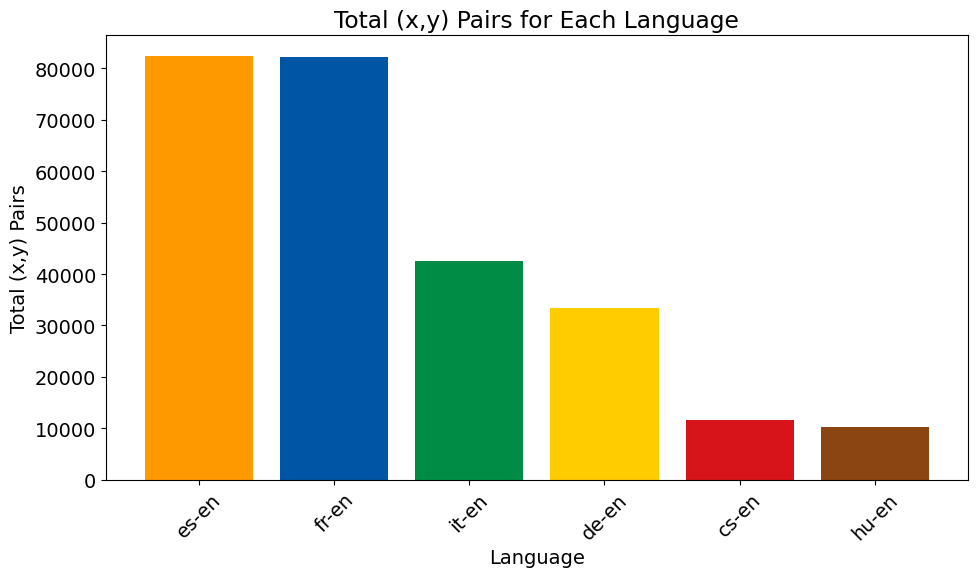

In [112]:
# Usage:
plot_n_samples(lang_dfs, color_mapping)
# plot_n_samples(lang_dfs_filtered, color_mapping)

/tmp/ipykernel_3883652/1772070432.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_colormap = plt.cm.get_cmap('coolwarm', len(models))


Saved plots to ./results/n-grams/exp_full/2/plots/wmt09-cs-en_wmt09-de-en_wmt09-fr-en_wmt09-es-en_wmt09-it-en_wmt09-hu-en_filter_False/distributions_1.pdf


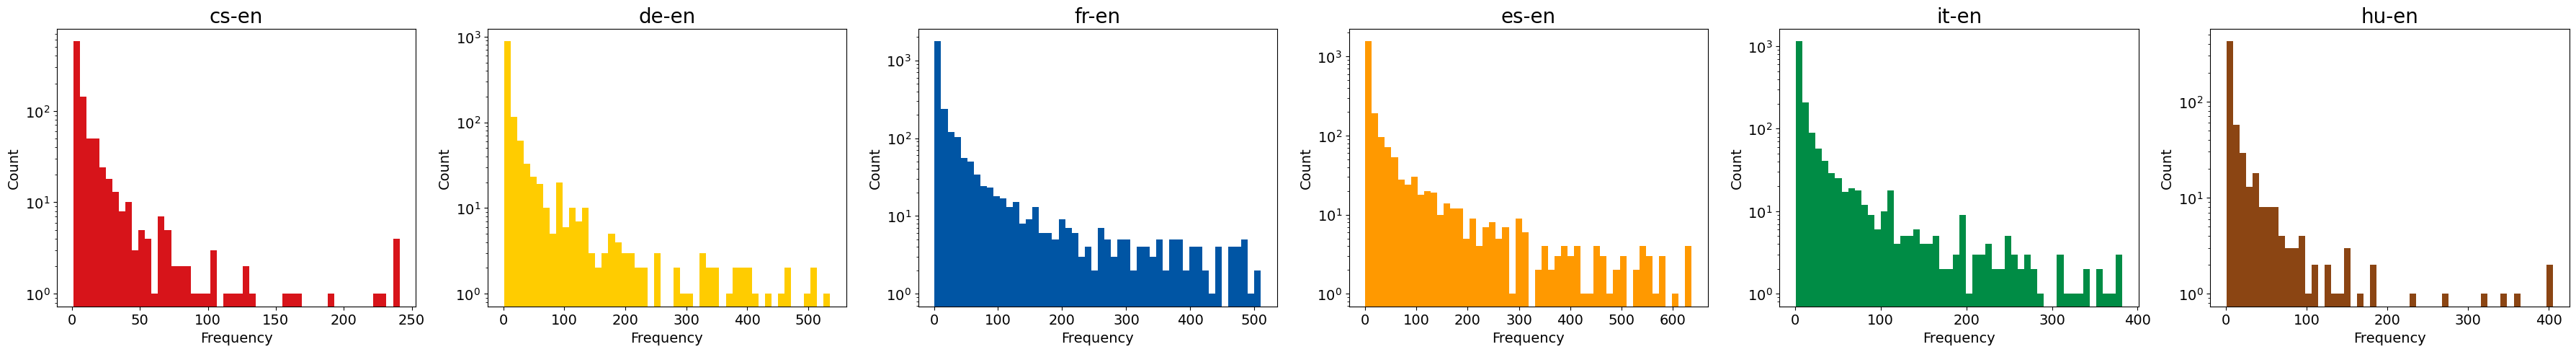

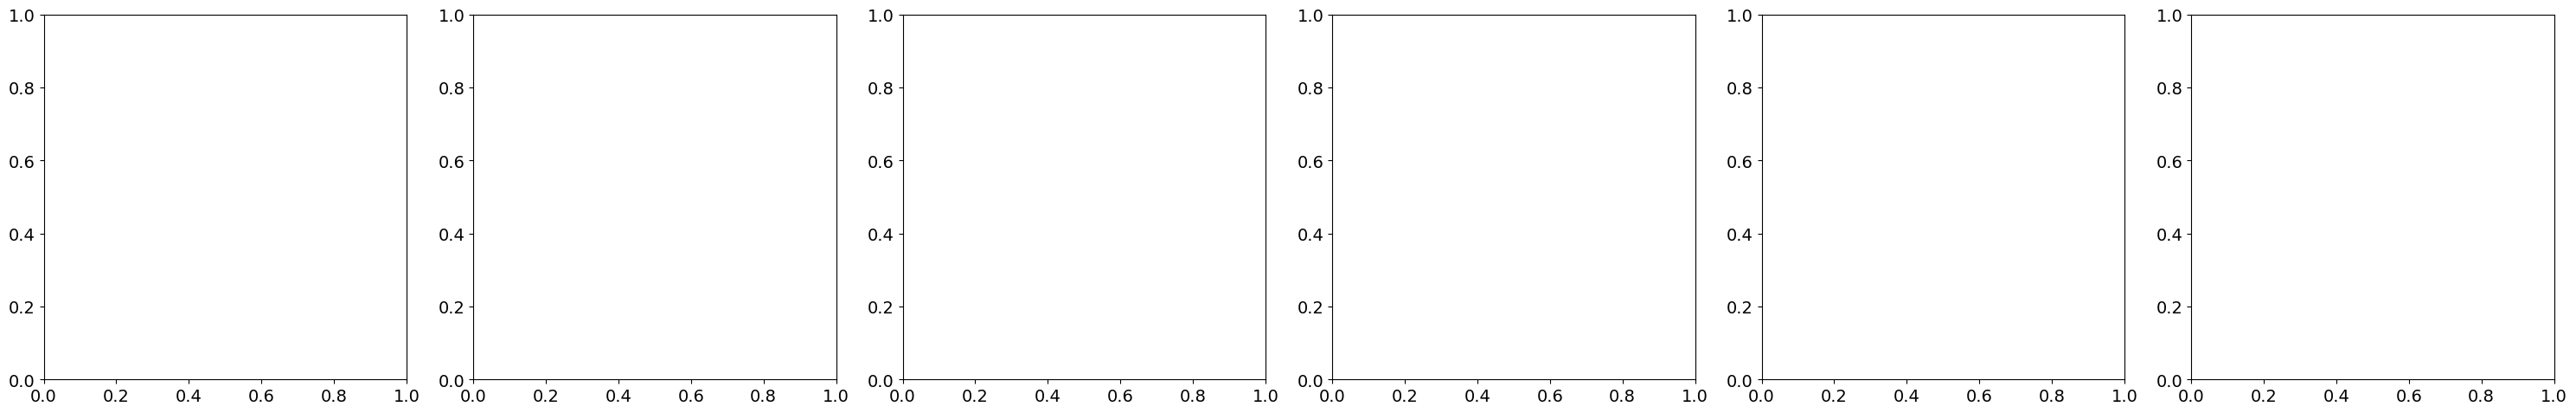

In [113]:
model_colormap = plt.cm.get_cmap('coolwarm', len(models))
model_color_mapping = {model: model_colormap(1 - i / len(models)) for i, model in enumerate(models)}
# Define country-specific colors


analyze_and_plot_distributions(lang_dfs, color_mapping)


In [114]:
# Initialize a dictionary to hold the contents of results.json for each model/dataset pair
results_dict = collections.defaultdict(dict)

# Iterate over each model and dataset, loading the results.json file
for model in models:
    for lang_dataset in LANGUAGES:
        lang_pair = '-'.join(lang_dataset.split('-')[-2:])
        results_path = os.path.join(base_results_path, model, "TRANSLATION", lang_dataset, '0-shot', 'results.json')
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as file:
                data = json.load(file)
                results_dict[lang_pair][model] = data['results'][lang_dataset]['bleu']
        else:
            print(f"File does not exist: {results_path}")


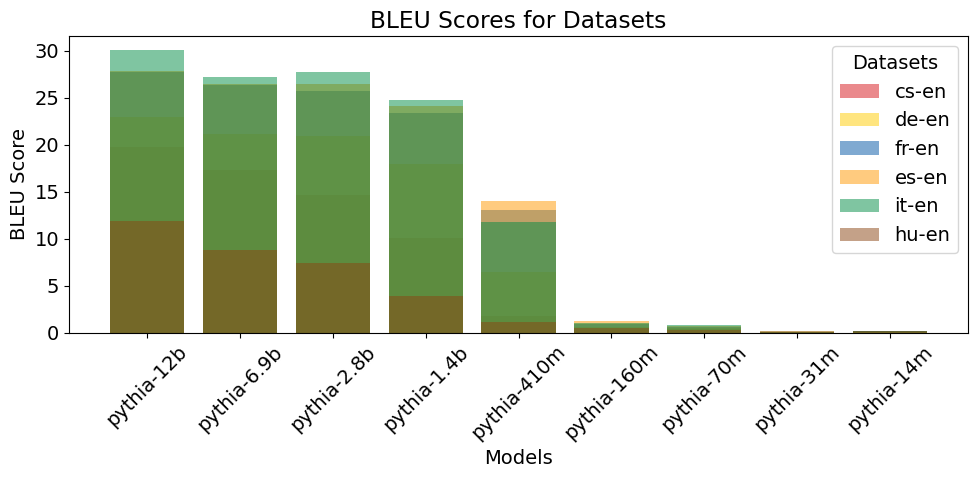

In [115]:
plot_bleu_scores(results_dict, models, color_mapping)

In [116]:
lang_dfs.keys()

dict_keys(['cs-en', 'de-en', 'fr-en', 'es-en', 'it-en', 'hu-en'])

In [117]:
lang_ds = wa.build_lang_ds(lang_dfs.keys())

lang_mutual_info, merged_mutual_info = wa.calculate_mutual_information(lang_dfs, lang_ds)

Loading dataset for language pair ('cs', 'en')
Loading dataset for language pair ('de', 'en')
Loading dataset for language pair ('fr', 'en')
Loading dataset for language pair ('es', 'en')
Loading dataset for language pair ('it', 'en')
Loading dataset for language pair ('hu', 'en')
Loading dataset for language pair ('en', 'cs')
Loading dataset for language pair ('en', 'de')
Loading dataset for language pair ('en', 'fr')
Loading dataset for language pair ('en', 'es')
Loading dataset for language pair ('en', 'it')
Loading dataset for language pair ('en', 'hu')


In [118]:
model_scores, dataset_scores = prepare_scores(results_dict, lang_dfs, models)

In [119]:
lang_dfs_all['hu-en']

,index,value,language,lang,coverage
0,per year,1455157,NaN,en,0.569485
1,czech republic,1451668,NaN,en,0.569485
2,three days,1434192,NaN,en,0.569485
3,human rights,1427842,NaN,en,0.569485
4,ever since,1410251,NaN,en,0.569485
...,...,...,...,...,...
34410,közötti feltételezett,1,NaN,hu,0.569485
34411,centreright coalition,1,NaN,en,0.569485
34412,köztudottan közel,1,NaN,hu,0.569485
34413,betting marine,1,NaN,en,0.569485


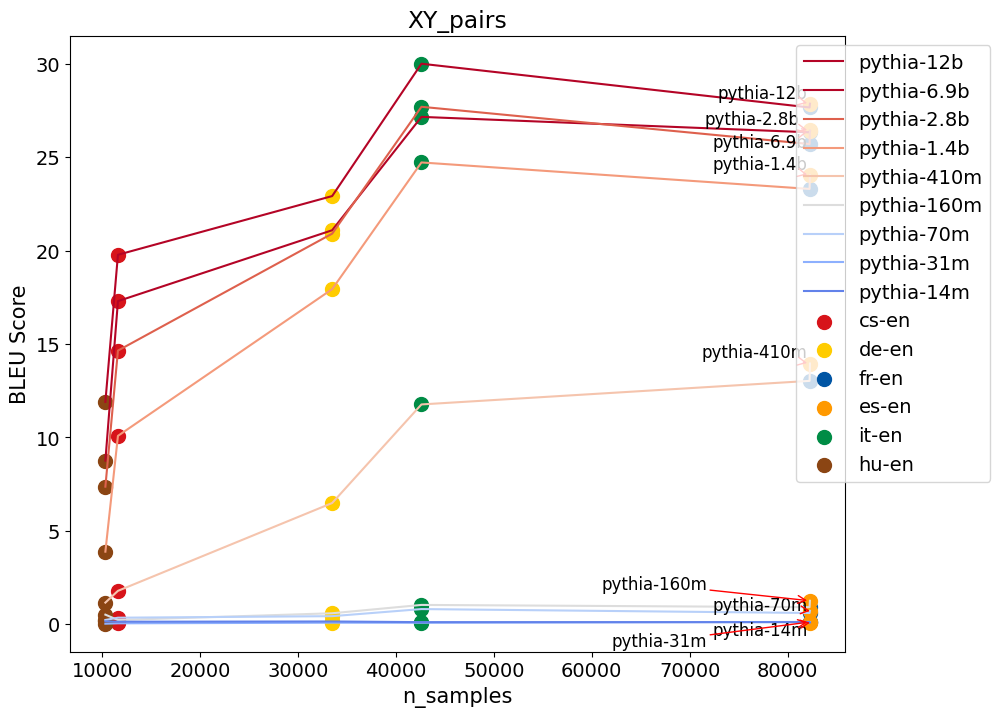

In [120]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# plot_scores(model_scores, dataset_scores, model_color_mapping, name="XY_pairs")
plot_scores(model_scores, dataset_scores, color_mapping,
            model_color_mapping, name="XY_pairs")

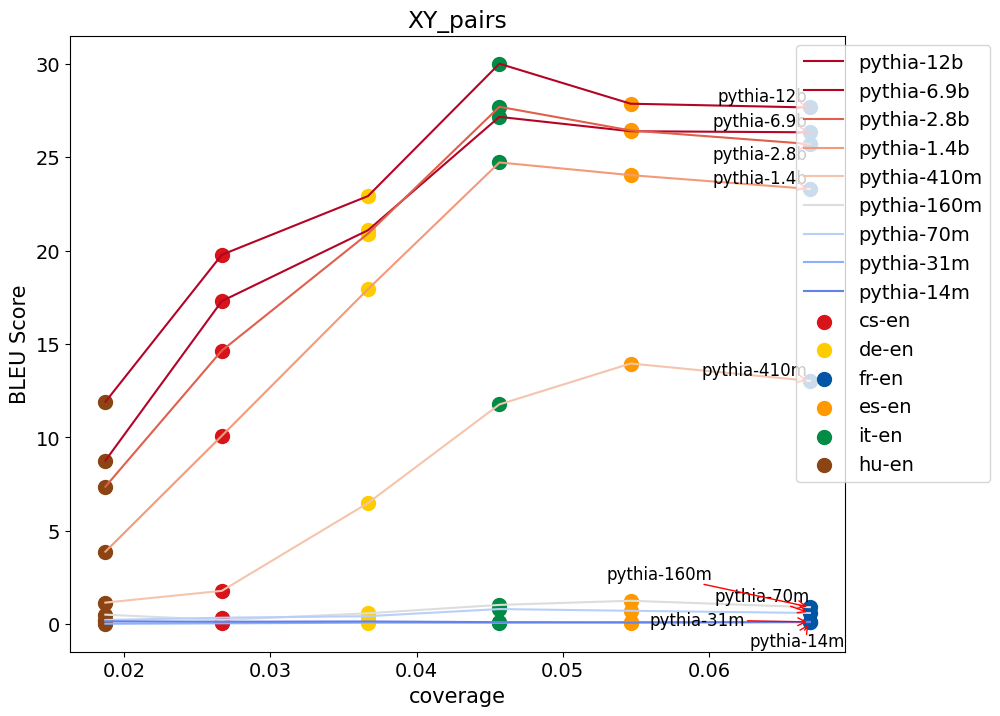

In [121]:
plot_scores(model_scores, dataset_scores, color_mapping,
            model_color_mapping, name="XY_pairs",
            x_key='coverage')

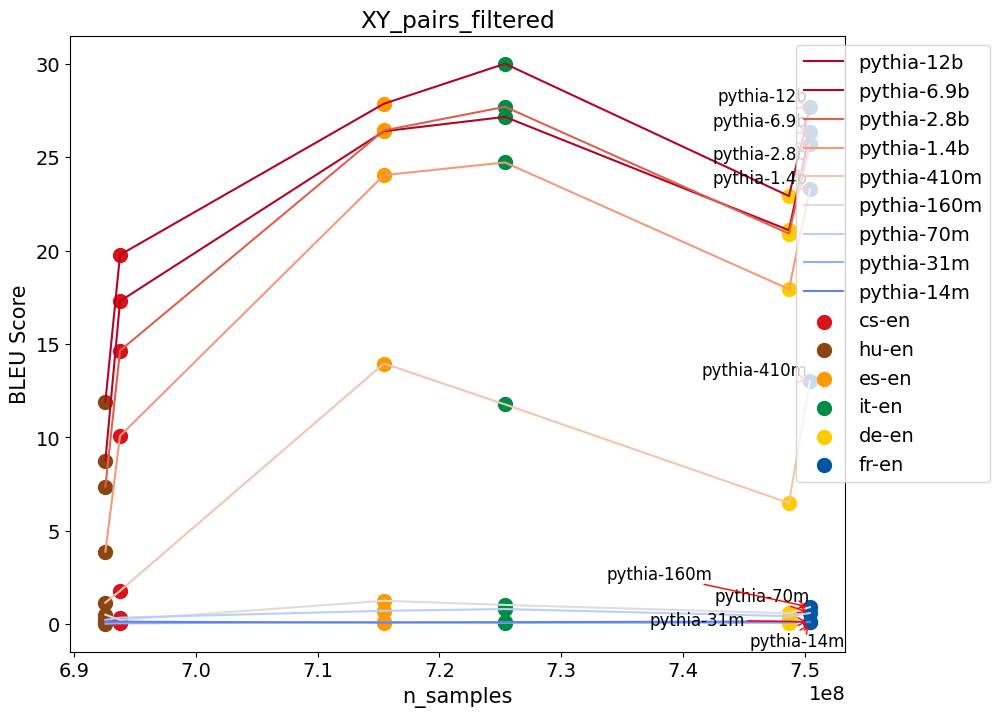

In [122]:
model_scores_filered, dataset_scores_filtered = prepare_scores(results_dict, lang_dfs_filtered, models)
plot_scores(model_scores_filered, dataset_scores_filtered, 
            color_mapping, model_color_mapping,
            name="XY_pairs_filtered")

In [123]:
# plot_scores(model_scores, dataset_scores, 
#             color_mapping, model_color_mapping,
#             name="XY_pairs",
#             x_key="mutual_info")

# plot_scores(model_scores, dataset_scores, 
#             color_mapping, model_color_mapping,
#             name="XY_pairs",
#             x_key="merged_mutual_info")

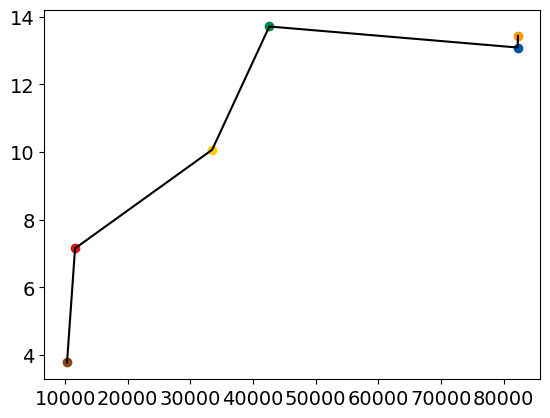

In [124]:
# plot average line over all models for all datasets
avg_dataset_scores = collections.defaultdict(lambda: collections.defaultdict(list))
avg_scores = {'score': [], 'n_samples': []} 
for dataset in dataset_scores:
    avg_dataset_scores[dataset]['score'] = np.mean(dataset_scores[dataset]['score'])
    avg_dataset_scores[dataset]['n_samples'] = np.mean(dataset_scores[dataset]['n_samples'])
    plt.scatter(avg_dataset_scores[dataset]['n_samples'], avg_dataset_scores[dataset]['score'], 
                color=color_mapping[dataset], label=dataset)
    avg_scores['score'].append(avg_dataset_scores[dataset]['score'])
    avg_scores['n_samples'].append(avg_dataset_scores[dataset]['n_samples'])

# sort by n_samples
avg_scores['score'] = [x for _, x in sorted(zip(avg_scores['n_samples'], avg_scores['score']))]
avg_scores['n_samples'] = sorted(avg_scores['n_samples'])

plt.plot(avg_scores['n_samples'], avg_scores['score'], color='black', label='average')

In [125]:
results_dict['fr-en'].keys()

dict_keys(['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m'])

dataset: cs-en
dataset: de-en
dataset: fr-en
dataset: es-en
dataset: it-en
dataset: hu-en
Saved figure to ./results/n-grams/exp_full/2/plots/model_size_vs_scores.png


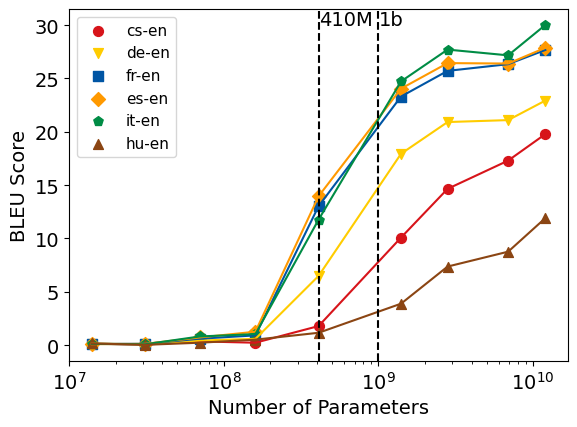

In [126]:
['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

# Define country-specific colors
color_mapping = {
    'fr-en': '#0055A4',   # France - Blue
    'es-en': '#FF9900',   # Spain - Orange
    'it-en': '#008C45',   # Italy - Green
    'de-en': '#FFCC00',   # Germany - Yellow
    'cs-en': '#D7141A',   # Czech Republic - Red
    'hu-en': '#8B4513'    # Hungary - SaddleBrown
}


model_param_map = {'pythia-12b': 12e09,
                    'pythia-6.9b': 6.9e09,
                    'pythia-2.8b': 2.8e09,
                    'pythia-1.4b': 1.4e09,
                    'pythia-410m': 410e06,
                    'pythia-160m': 160e06,
                    'pythia-70m': 70e06,
                    'pythia-31m': 31e06,
                    'pythia-14m': 14e06,}

wa.plot_model_size_vs_scores(results_dict, models, model_param_map, color_mapping)

Saved plots to ./results/n-grams/exp_full/2/plots/wmt09-cs-en_wmt09-de-en_wmt09-fr-en_wmt09-es-en_wmt09-it-en_wmt09-hu-en_filter_False/distributions_1.pdf


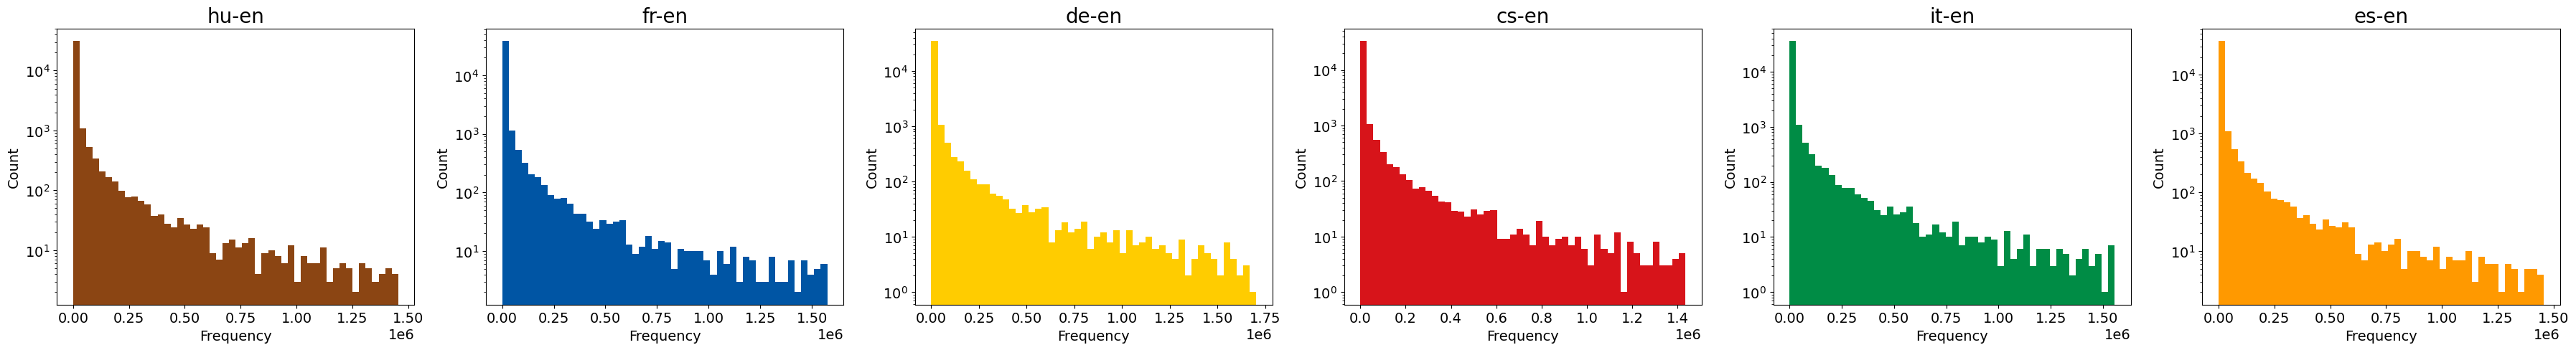

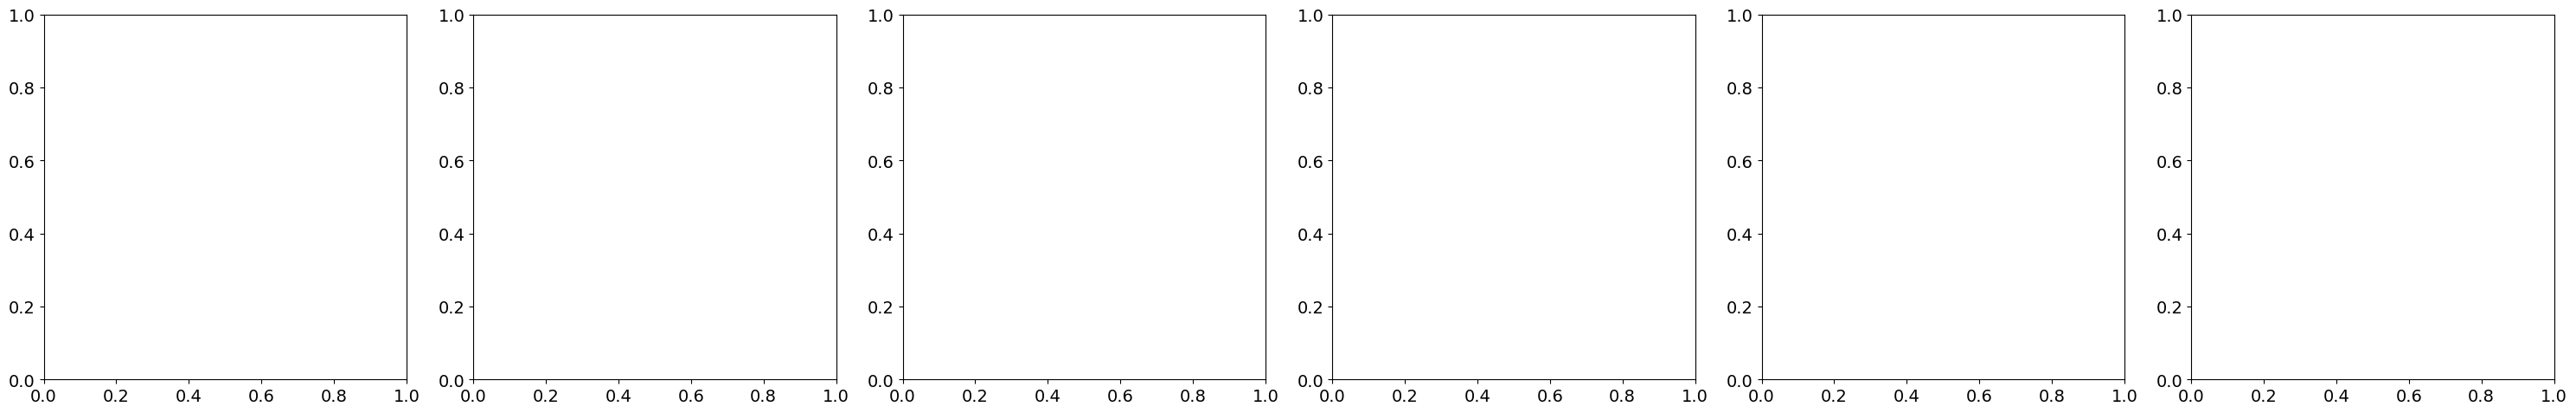

In [127]:
analyze_and_plot_distributions(lang_dfs_all, color_mapping)

In [128]:
# get total samples per language
lang_dfs_all_total_samples = {}
for lang, df in lang_dfs_all.items():
    lang_dfs_all_total_samples[lang] = df['value'].sum()

model_scores_all, dataset_scores_all = prepare_scores(results_dict, lang_dfs_all, models)

In [129]:
# n_gram_freqs_all['ja-en']['value'] = pd.to_numeric(n_gram_freqs_all['ja-en']['value'], errors='coerce')
# largest_values = n_gram_freqs_all['ja-en'].nlargest(50, columns=['value'])

# print(largest_values)

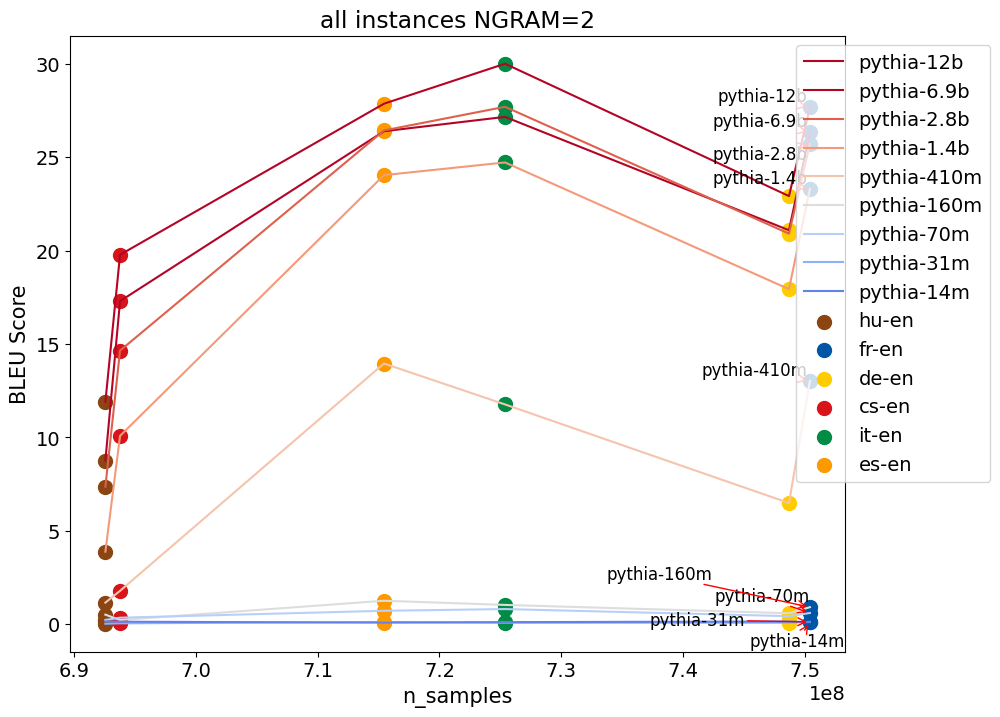

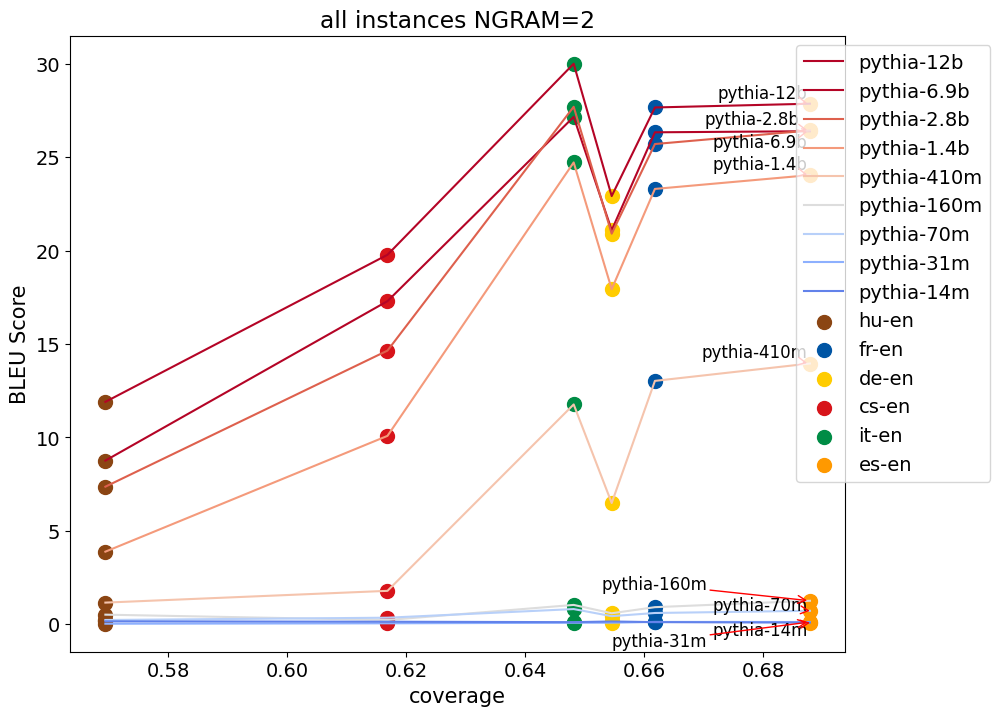

In [130]:
plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"all instances NGRAM={N_GRAMS}")

plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"all instances NGRAM={N_GRAMS}",
            x_key="coverage")

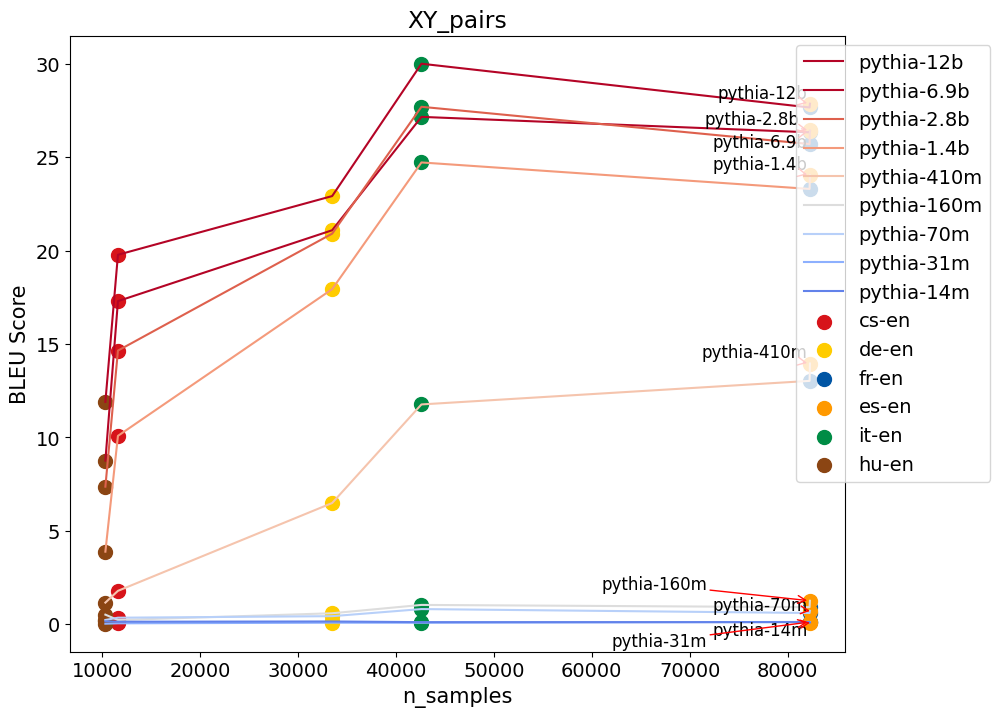

In [131]:
plot_scores(model_scores, dataset_scores, 
            color_mapping, model_color_mapping, 
            name="XY_pairs")

In [132]:
lang_dfs_all.keys()

dict_keys(['hu-en', 'fr-en', 'de-en', 'cs-en', 'it-en', 'es-en'])

In [133]:
lang = 'fr'

for lang_pair in lang_dfs_all:
    lang = lang_pair.split('-')[0]
    lang_en_all = lang_dfs_all[f'{lang}-en']
    lang_only = lang_en_all[lang_en_all['lang'] == lang]
    print(f"lang all: {len(lang_en_all)} only: {len(lang_only)} diff: {len(lang_en_all) - len(lang_only)}")

lang all: 34415 only: 7212 diff: 27203
lang all: 41670 only: 14457 diff: 27213
lang all: 37881 only: 10664 diff: 27217
lang all: 36552 only: 9353 diff: 27199
lang all: 39458 only: 12248 diff: 27210
lang all: 41024 only: 13824 diff: 27200


In [134]:
lang = 'fr'

for lang_pair in lang_dfs:
    lang = lang_pair.split('-')[0]
    lang_en_all = lang_dfs_all[f'{lang}-en']
    lang_only = lang_en_all[lang_en_all['lang'] == lang]
    print(f"lang all: {len(lang_en_all)} only: {len(lang_only)} diff: {len(lang_en_all) - len(lang_only)}")

lang_dfs_all_single = {lang_pair: df[df['lang'] == lang_pair.split('-')[0]] for lang_pair, df in lang_dfs_all.items()}
model_scores_all_single, dataset_scores_all_single = prepare_scores(results_dict, lang_dfs_all_single, models)

lang all: 36552 only: 9353 diff: 27199
lang all: 37881 only: 10664 diff: 27217
lang all: 41670 only: 14457 diff: 27213
lang all: 41024 only: 13824 diff: 27200
lang all: 39458 only: 12248 diff: 27210
lang all: 34415 only: 7212 diff: 27203


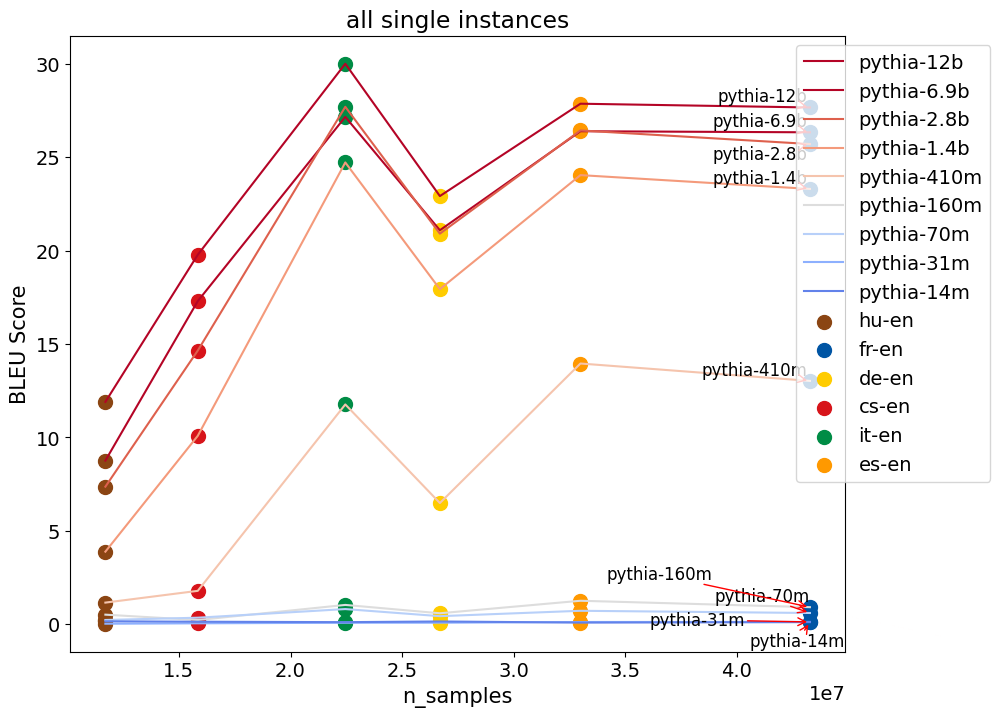

In [135]:
plot_scores(model_scores_all_single, dataset_scores_all_single, 
            color_mapping, model_color_mapping, 
            name="all single instances")